# imports

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [5]:
from pathlib import Path
import torch
from datasets import load_dataset
from transformers import ConvNextV2ForImageClassification, ConvNextV2Config
from torch.utils.data import DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt
from tqdm import tqdm


# cifar10 test

In [2]:
RUNS_DIR = "/mnt/ssd-1/adam/basin-volume/runs"

In [7]:
def evaluate_checkpoints(model_path):
    """
    Evaluate model checkpoints and plot training progress.
    
    Args:
        model_path (str): Path after /mnt/ssd-1/adam/basin-volume/runs/
                         e.g., "cifar10/convnext"
    """
    RUNS_DIR = "/mnt/ssd-1/adam/basin-volume/runs"
    
    # Load and process datasets
    ds = load_dataset("cifar10")
    train_ds = ds["train"]
    val_ds = ds["test"]
    
    transform = T.Compose([T.ToTensor()])
    
    def preprocess(examples):
        return {
            "pixel_values": [transform(image.convert("RGB")) for image in examples["img"]],
            "label": examples["label"]
        }
    
    train_ds = train_ds.map(preprocess, batched=True, remove_columns=train_ds.column_names)
    val_ds = val_ds.map(preprocess, batched=True, remove_columns=val_ds.column_names)
    train_ds.set_format(type="torch")
    val_ds.set_format(type="torch")
    
    train_loader = DataLoader(train_ds, batch_size=128, num_workers=4)
    val_loader = DataLoader(val_ds, batch_size=128, num_workers=4)
    
    # Get checkpoints
    checkpoints = sorted(
        Path(RUNS_DIR, model_path).glob("checkpoint-*"),
        key=lambda x: int(x.name.split("-")[1])
    )
    
    train_accuracies = []
    val_accuracies = []
    train_losses = []
    val_losses = []
    steps = []
    
    for ckpt in tqdm(checkpoints):
        config = ConvNextV2Config.from_pretrained(ckpt)
        model = ConvNextV2ForImageClassification.from_pretrained(
            ckpt,
            config=config,
            torch_dtype=torch.float16
        ).cuda()
        model.eval()
        
        # Evaluate on both sets
        for loader, accuracies, losses in [(train_loader, train_accuracies, train_losses),
                                         (val_loader, val_accuracies, val_losses)]:
            correct = 0
            total = 0
            running_loss = 0.0
            
            with torch.no_grad():
                for batch in loader:
                    pixel_values = batch["pixel_values"].cuda().to(torch.float16)
                    labels = batch["label"].cuda()
                    
                    outputs = model(pixel_values, labels=labels)
                    predictions = outputs.logits.argmax(-1)
                    
                    correct += (predictions == labels).sum().item()
                    total += labels.size(0)
                    running_loss += outputs.loss.item() * labels.size(0)
            
            accuracy = correct / total
            avg_loss = running_loss / total
            if loader == train_loader:  # Only add steps once
                step = int(ckpt.name.split("-")[1])
                steps.append(step)
                print(f"Step {step}: Train acc: {accuracy:.3f}, loss: {avg_loss:.3f}", end="")
            else:
                print(f", Val acc: {accuracy:.3f}, loss: {avg_loss:.3f}")
            accuracies.append(accuracy)
            losses.append(avg_loss)
    
    # Create plots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
    
    # Plot accuracies
    ax1.semilogx(steps, train_accuracies, "-o", label="Train")
    ax1.semilogx(steps, val_accuracies, "-o", label="Validation")
    ax1.grid(True)
    ax1.set_ylabel("Accuracy")
    ax1.set_title(f"Training Progress for {model_path}")
    ax1.legend()
    
    # Plot losses
    ax2.semilogx(steps, train_losses, "-o", label="Train")
    ax2.semilogx(steps, val_losses, "-o", label="Validation")
    ax2.grid(True)
    ax2.set_xlabel("Training Steps")
    ax2.set_ylabel("Cross Entropy Loss")
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

    return train_accuracies, val_accuracies, train_losses, val_losses

  0%|          | 0/17 [00:00<?, ?it/s]

Step 1: Train acc: 0.100, loss: 2.309

  6%|▌         | 1/17 [00:16<04:31, 16.95s/it]

, Val acc: 0.100, loss: 2.308
Step 2: Train acc: 0.100, loss: 2.309

 12%|█▏        | 2/17 [00:31<03:55, 15.71s/it]

, Val acc: 0.100, loss: 2.308
Step 4: Train acc: 0.100, loss: 2.307

 18%|█▊        | 3/17 [00:46<03:34, 15.34s/it]

, Val acc: 0.100, loss: 2.306
Step 8: Train acc: 0.103, loss: 2.299

 24%|██▎       | 4/17 [01:01<03:18, 15.23s/it]

, Val acc: 0.104, loss: 2.298
Step 16: Train acc: 0.137, loss: 2.286

 29%|██▉       | 5/17 [01:17<03:04, 15.34s/it]

, Val acc: 0.141, loss: 2.285
Step 32: Train acc: 0.141, loss: 2.262

 35%|███▌      | 6/17 [01:32<02:48, 15.29s/it]

, Val acc: 0.145, loss: 2.261
Step 64: Train acc: 0.166, loss: 2.166

 41%|████      | 7/17 [01:47<02:32, 15.24s/it]

, Val acc: 0.166, loss: 2.166
Step 128: Train acc: 0.196, loss: 2.125

 47%|████▋     | 8/17 [02:02<02:16, 15.17s/it]

, Val acc: 0.189, loss: 2.126
Step 256: Train acc: 0.318, loss: 1.884

 53%|█████▎    | 9/17 [02:17<02:01, 15.23s/it]

, Val acc: 0.320, loss: 1.886
Step 512: Train acc: 0.396, loss: 1.656

 59%|█████▉    | 10/17 [02:33<01:46, 15.17s/it]

, Val acc: 0.399, loss: 1.658
Step 1024: Train acc: 0.448, loss: 1.524

 65%|██████▍   | 11/17 [02:48<01:30, 15.14s/it]

, Val acc: 0.449, loss: 1.532
Step 2048: Train acc: 0.540, loss: 1.255

 71%|███████   | 12/17 [03:03<01:15, 15.12s/it]

, Val acc: 0.528, loss: 1.277
Step 4096: Train acc: 0.761, loss: 0.677

 76%|███████▋  | 13/17 [03:18<01:00, 15.16s/it]

, Val acc: 0.733, loss: 0.756
Step 8192: Train acc: 0.876, loss: 0.352

 82%|████████▏ | 14/17 [03:33<00:45, 15.18s/it]

, Val acc: 0.835, loss: 0.500
Step 16384: Train acc: 0.957, loss: 0.120

 88%|████████▊ | 15/17 [03:48<00:30, 15.07s/it]

, Val acc: 0.883, loss: 0.375
Step 32768: Train acc: 0.996, loss: 0.013

 94%|█████████▍| 16/17 [04:03<00:15, 15.07s/it]

, Val acc: 0.909, loss: 0.345
Step 65536: Train acc: 1.000, loss: 0.000

100%|██████████| 17/17 [04:18<00:00, 15.20s/it]

, Val acc: 0.930, loss: 0.378


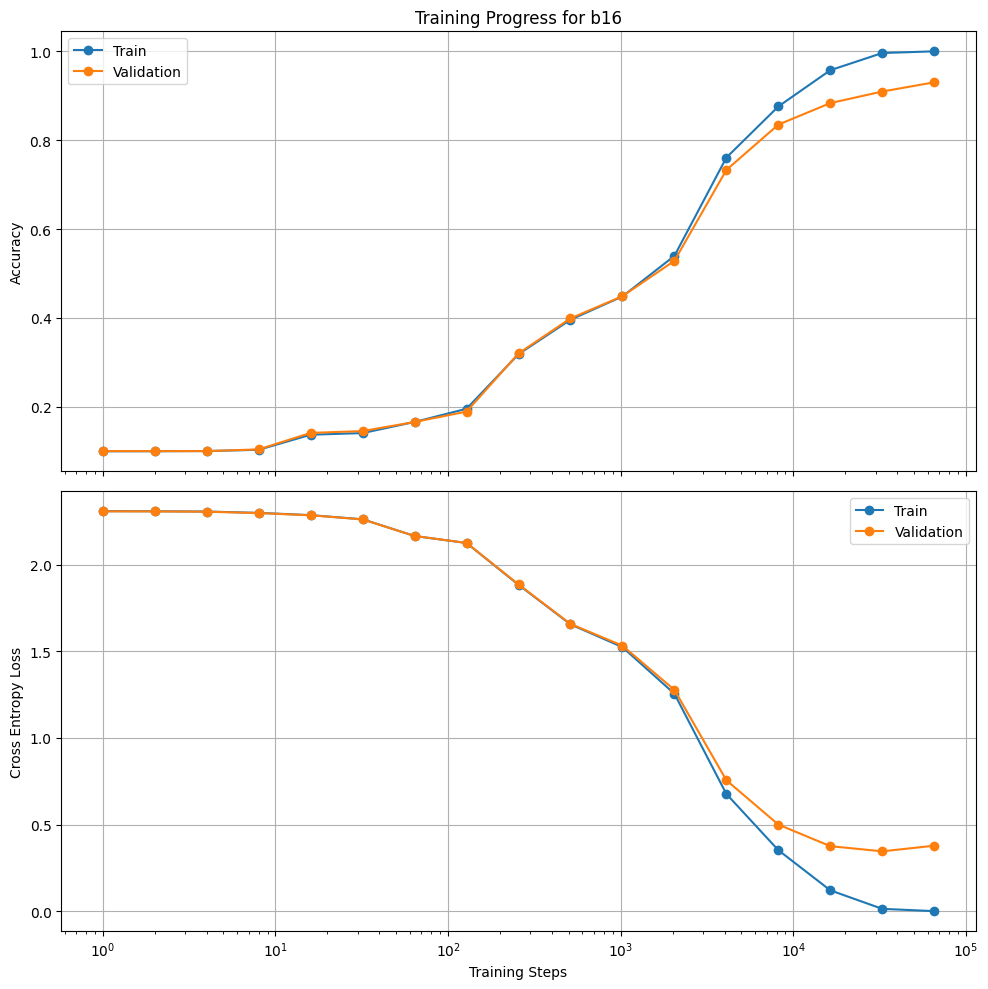

In [8]:
metrics = evaluate_checkpoints("b16")